In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

## Creating and training model

# Train and Test data

In [52]:
# train
trainDataRaw = pd.read_csv('../../../datasets/fraudTrain.csv')
print(trainDataRaw.shape)
print(trainDataRaw.head())

(1296675, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suit

In [53]:
# test
testDataRaw = pd.read_csv('../../../datasets/fraudTest.csv')
print(testDataRaw.shape)
print(testDataRaw.head())

(555719, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Union  

# Selección de variables 

# Feature Importance (RandomForest)

In [5]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [6]:
Xforest = trainDataRaw  # Variables independientes

In [7]:
# Date encoding
Xforest['hour'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.hour
Xforest['day'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.day_of_week
Xforest['month'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.month

In [8]:
column = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'gender', 'state', 'city', 'job', 'street', 'zip', 'dob', 'trans_num', 'unix_time', 'is_fraud']
Xforest = Xforest.drop(columns=column)

In [9]:
# Category one-hot encoding
Xforest = pd.get_dummies(Xforest, columns=['category'], drop_first=True)

In [15]:
Xforest.head()

,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,category_food_dining,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0,1,1,False,...,False,False,False,False,True,False,False,False,False,False
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0,1,1,False,...,True,False,False,False,False,False,False,False,False,False
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0,1,1,False,...,False,False,False,False,False,False,False,False,False,False
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0,1,1,False,...,False,False,False,False,False,False,False,False,False,False
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0,1,1,False,...,False,False,False,False,False,True,False,False,False,False


In [16]:
Xforest.shape

(1296675, 22)

In [17]:
yforest = trainDataRaw['is_fraud']  # Variable objetivo

In [18]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)

In [19]:
forest.fit(Xforest, yforest)

RandomForestClassifier(random_state=0)

In [20]:
best_ftr = forest.feature_importances_

In [21]:
# Crea un DataFrame para visualizar las importancias
best_ftr_df = pd.DataFrame({'Feature': Xforest.columns, 'Importance': best_ftr})

# Ordena las características por importancia
best_ftr_df = best_ftr_df.sort_values(by='Importance', ascending=False)


In [22]:
print(best_ftr_df)

                    Feature  Importance
0                       amt    0.501066
6                      hour    0.088306
12     category_grocery_pos    0.057155
5                merch_long    0.051815
4                 merch_lat    0.051439
3                  city_pop    0.047209
2                      long    0.042285
1                       lat    0.042018
8                     month    0.024647
10   category_gas_transport    0.020984
7                       day    0.020492
16        category_misc_net    0.011313
17        category_misc_pos    0.010184
19    category_shopping_net    0.008997
21          category_travel    0.006904
20    category_shopping_pos    0.006398
14            category_home    0.003059
9      category_food_dining    0.001251
11     category_grocery_net    0.001223
15       category_kids_pets    0.001156
13  category_health_fitness    0.001066
18   category_personal_care    0.001031


# Correlation 

In [23]:
Xcorr= trainDataRaw

In [24]:
Xcorr.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1


In [25]:
# Date encoding
Xcorr['hour'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.hour
Xcorr['day'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.day_of_week
Xcorr['month'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.month

In [27]:
column = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'gender', 'state', 'city', 'job', 'street', 'zip', 'dob', 'trans_num', 'unix_time']
Xcorr = Xcorr.drop(columns=column)

In [28]:
# Category one-hot encoding
Xcorr = pd.get_dummies(Xcorr, columns=['category'], drop_first=True)

In [29]:
Xcorr.head()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,hour,day,month,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0,0,1,1,...,False,False,False,False,True,False,False,False,False,False
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0,0,1,1,...,True,False,False,False,False,False,False,False,False,False
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0,0,1,1,...,False,False,False,False,False,True,False,False,False,False


In [31]:
corre_fraud = Xcorr.corrwith(Xcorr['is_fraud'])

corre_fraud = corre_fraud.abs().sort_values(ascending=False)

In [32]:
print(corre_fraud)

is_fraud                   1.000000
amt                        0.219404
category_shopping_net      0.044261
category_grocery_pos       0.035558
category_misc_net          0.025886
category_home              0.017848
category_food_dining       0.015025
category_kids_pets         0.014967
category_health_fitness    0.014885
hour                       0.013799
month                      0.012409
category_personal_care     0.012167
category_misc_pos          0.008937
category_grocery_net       0.007136
category_travel            0.006924
category_shopping_pos      0.005955
category_gas_transport     0.004851
city_pop                   0.002136
lat                        0.001894
merch_lat                  0.001741
day                        0.001739
merch_long                 0.001721
long                       0.001721
dtype: float64


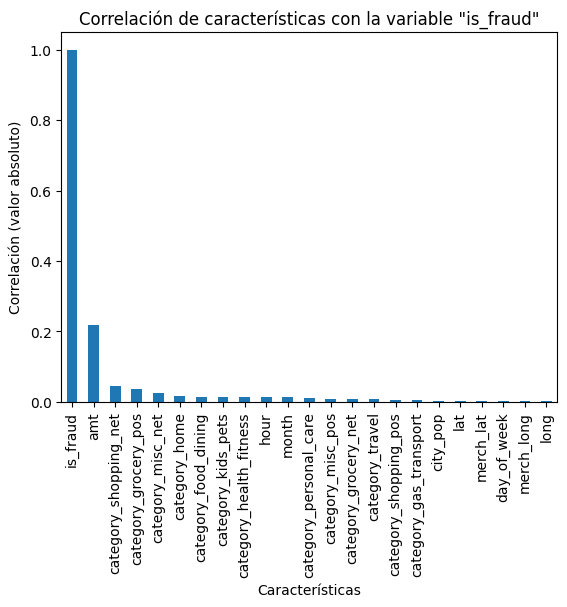

In [50]:
corre_fraud.plot(kind='bar')

plt.title('Correlación de características con la variable "is_fraud"')
plt.xlabel('Características')
plt.ylabel('Correlación (valor absoluto)')
plt.show()

# Data cleaning (trainData)

In [55]:
columns_out = ['Unnamed: 0', 'cc_num', 'merchant', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'city', 'job', 'dob', 'trans_num', 'unix_time']

In [72]:
trainData = trainDataRaw.drop(columns=columns_out)
testData = testDataRaw.drop(columns=columns_out)

In [58]:
print(trainData.shape)
trainData.head()

(1296675, 9)


,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,misc_net,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0
1,2019-01-01 00:00:44,grocery_pos,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0
2,2019-01-01 00:00:51,entertainment,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0
3,2019-01-01 00:01:16,gas_transport,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0
4,2019-01-01 00:03:06,misc_pos,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0


In [59]:
# Category encoding
Xtrain = pd.get_dummies(trainData, columns=['category'], prefix=['cat'])
Xtrain = Xtrain.drop(columns=['is_fraud'])
# Date encoding
Xtrain['hour'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.hour
Xtrain['day'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.day_of_week
Xtrain['month'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.month
Xtrain = Xtrain.drop(columns=['trans_date_trans_time'])
print(Xtrain.shape)

(1296675, 23)


In [60]:
Xtrain.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,False,False,False,False,...,False,True,False,False,False,False,False,0,1,1
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,False,False,False,False,...,False,False,False,False,False,False,False,0,1,1
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,True,False,False,False,...,False,False,False,False,False,False,False,0,1,1
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,False,False,True,False,...,False,False,False,False,False,False,False,0,1,1
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,False,False,False,False,...,False,False,True,False,False,False,False,0,1,1


In [61]:
ytrain = trainData['is_fraud']
print(ytrain.head())
print(ytrain.shape)

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64
(1296675,)


# Training the model (trainData)

In [62]:
X, Xtest, y, ytest = train_test_split(Xtrain, ytrain, test_size=0.20, random_state=42, stratify=ytrain)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

In [63]:
# Modelo feed-forward
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# X.shape[1] = 23

In [65]:
# Learning rate for Adam
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [66]:
# Compile
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# Train 
model.fit(X, y, epochs=10, batch_size=32, validation_data=(Xtest, ytest))
model.save('detectorV2.h5')

Epoch 1/10
32417/32417 [==============================] - 47s 1ms/step - loss: 0.0195 - accuracy: 0.9959 - val_loss: 0.0140 - val_accuracy: 0.9969
Epoch 2/10
32417/32417 [==============================] - 46s 1ms/step - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0118 - val_accuracy: 0.9970
Epoch 3/10
32417/32417 [==============================] - 45s 1ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0100 - val_accuracy: 0.9972
Epoch 4/10
32417/32417 [==============================] - 46s 1ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0094 - val_accuracy: 0.9976
Epoch 5/10
32417/32417 [==============================] - 46s 1ms/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.0096 - val_accuracy: 0.9975
Epoch 6/10
32417/32417 [==============================] - 47s 1ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.0088 - val_accuracy: 0.9977
Epoch 7/10
32417/32417 [==============================] - 46s 1ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
# Evaluate the model
predict = model.predict(Xtest)

8105/8105 [==============================] - 7s 860us/step


In [69]:
predict = (predict > 0.5) # if prob > 0.5 is fraud and vice versa

In [70]:
# Confusion matrix 
confusion = confusion_matrix(ytest, predict)
print("Confusion Matrix:")
print(confusion)
# Correct 0 - Incorrect 1
# Incorrect 0 - Correct 1

Confusion Matrix:
[[257682    152]
 [   453   1048]]


In [71]:
# Classification report
report = classification_report(ytest, predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.87      0.70      0.78      1501

    accuracy                           1.00    259335
   macro avg       0.94      0.85      0.89    259335
weighted avg       1.00      1.00      1.00    259335



# Model Checking

In [73]:
print(testDataRaw.shape)
print(testData.shape)

(555719, 23)
(555719, 9)


In [77]:
# Category encoding
XtestCheck = pd.get_dummies(testData, columns=['category'], prefix=['cat'])
XtestCheck = XtestCheck.drop(columns=['is_fraud'])
# Date encoding
XtestCheck['hour'] = pd.to_datetime(testData['trans_date_trans_time']).dt.hour
XtestCheck['day'] = pd.to_datetime(testData['trans_date_trans_time']).dt.day_of_week
XtestCheck['month'] = pd.to_datetime(testData['trans_date_trans_time']).dt.month
XtestCheck = XtestCheck.drop(columns=['trans_date_trans_time'])
print(XtestCheck.shape)

(555719, 23)


In [78]:
XtestCheck.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
1,29.84,40.3207,-110.4360,302,39.450498,-109.960431,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
2,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,False,False,False,False,...,False,False,False,False,False,False,False,12,6,6
3,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,False,False,False,False,...,False,False,True,False,False,False,False,12,6,6
4,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,False,False,False,False,...,False,False,False,False,False,False,True,12,6,6


In [79]:
scaler = StandardScaler()
XtestCheck = scaler.fit_transform(XtestCheck)
XtestCheck = scaler.transform(XtestCheck)

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [80]:
XtestCheck.shape

(555719, 23)

In [81]:
loaded_model = tf.keras.models.load_model("detectorV2.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
y_pred = loaded_model.predict(XtestCheck)

17367/17367 [==============================] - 16s 911us/step


In [83]:
testData.head()

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:33,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:53,health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:15,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:17,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [84]:
testData['predict'] = y_pred
testData.head()

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,predict
0,2020-06-21 12:14:25,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0,1.181407e-08
1,2020-06-21 12:14:33,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0,1.127027e-08
2,2020-06-21 12:14:53,health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0,1.365744e-11
3,2020-06-21 12:15:15,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0,2.502212e-12
4,2020-06-21 12:15:17,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0,1.056386e-18


In [85]:
threshold = 0.5
fraudRows = testData[y_pred > threshold]

In [86]:
print(fraudRows)

Empty DataFrame
Columns: [trans_date_trans_time, category, amt, lat, long, city_pop, merch_lat, merch_long, is_fraud, predict]
Index: []


In [89]:
testData.head(1686)

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,predict
0,2020-06-21 12:14:25,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0,1.181407e-08
1,2020-06-21 12:14:33,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0,1.127027e-08
2,2020-06-21 12:14:53,health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0,1.365744e-11
3,2020-06-21 12:15:15,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0,2.502212e-12
4,2020-06-21 12:15:17,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0,1.056386e-18
...,...,...,...,...,...,...,...,...,...,...
1681,2020-06-21 22:04:05,personal_care,49.43,34.8470,-98.9836,551,35.372188,-98.390298,0,1.095241e-08
1682,2020-06-21 22:05:07,home,89.82,39.0305,-76.5515,92106,38.400359,-76.923792,0,1.726445e-19
1683,2020-06-21 22:06:30,personal_care,85.45,41.4802,-86.6919,1423,41.214552,-86.874168,0,1.116270e-08
1684,2020-06-21 22:06:31,food_dining,57.13,36.3011,-91.5281,4726,35.614887,-92.183553,0,2.396859e-14
